# Loading Data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

def obj_to_float(x):
    try:
        return(float(x))
    except:
        return(None)

def map_maker(col):
    ''' 
    col=col containing categorical features in str format
    output a dictionary where
    key=string, value=incrementing int value
    '''
    string_to_int={}
    for val,key in enumerate(set(col)):
        string_to_int[key]=val
    if(set(string_to_int.keys()).difference(set(['No','Yes']))==set()):    
        string_to_int['Yes']=1
        string_to_int['No']=0
    return(string_to_int) 

class data:
    def __init__(self,path):
        self.data=pd.read_csv(path)
        
        features,mappings=self.mk_features()
        self.features=features
        self.mappings=mappings
        return(None)
    
    def mk_features(self):
        features=self.data.copy()

        features=features.drop(labels='customerID',axis=1)
        
        features.TotalCharges=features.TotalCharges.apply(obj_to_float)
        
        obj_col=list(map(lambda x:features[x].dtype=='O',features.columns))
        categorical_mappings=features.iloc[:,obj_col].apply(map_maker,axis=0)
        for dictionary,colName in zip(categorical_mappings,features.iloc[:,obj_col].columns):
            features[colName]=features[colName].apply(lambda x:dictionary[x])
        return(features.dropna(),categorical_mappings)
    
churn=data('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
data=churn.data
categorical_mappings=churn.mappings
features=churn.features

# Data Exploration

In [2]:
#data.head()

In [3]:
#features.head()

## Statistics

In [4]:
features.describe()[['tenure','MonthlyCharges','TotalCharges','SeniorCitizen']]

,tenure,MonthlyCharges,TotalCharges,SeniorCitizen
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441,0.162400
std,24.545260,30.085974,2266.771362,0.368844
min,1.000000,18.250000,18.800000,0.000000
25%,9.000000,35.587500,401.450000,0.000000
50%,29.000000,70.350000,1397.475000,0.000000
75%,55.000000,89.862500,3794.737500,0.000000
max,72.000000,118.750000,8684.800000,1.000000


## Visualizations

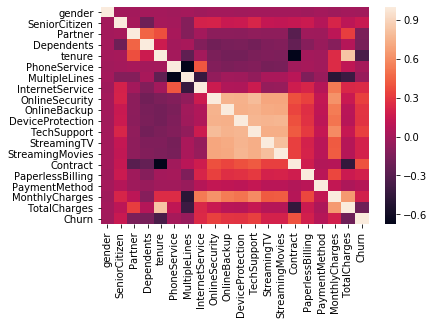

In [5]:
%matplotlib inline

sns.heatmap(features.corr())

In [6]:
#features.corr()

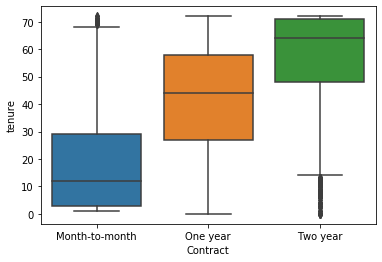

In [7]:
sns.boxplot(x='Contract',y='tenure',data=data)

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

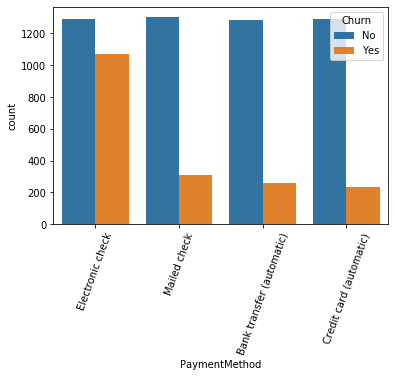

In [8]:

sns.countplot(x='PaymentMethod',hue='Churn',data=data)
plt.xticks(rotation=70)

In [9]:
#sns.countplot(x='SeniorCitizen',hue='Churn',data=data)

In [10]:
#sns.countplot(x='gender',hue='Churn',data=data)

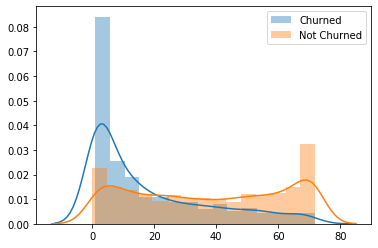

In [11]:
#tenure vs churn

nbin=15
sns.distplot(list(data[data.Churn=='Yes']['tenure']),label='Churned',bins=nbin)
sns.distplot(list(data[data.Churn=='No']['tenure']),label='Not Churned',bins=nbin)
plt.legend()

In [12]:
#np.array(data[data.Churn=='Yes'].tenure)

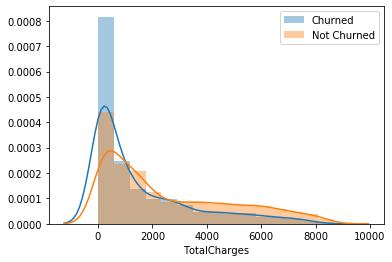

In [13]:
nbin=15
sns.distplot(features[features.Churn==1]['TotalCharges'],label='Churned',bins=nbin)
sns.distplot(features[features.Churn==0]['TotalCharges'],label='Not Churned',bins=nbin)
plt.legend()

# Models

In [14]:
n=.75
sample=features.sample(frac=1)
sample=sample.dropna()
train=sample.iloc[:int(sample.shape[0]*n),:]
test=sample.iloc[int(sample.shape[0]*n):,:]

In [15]:

logr=LogisticRegression(solver='lbfgs',max_iter=10**6)

logr.fit(train.iloc[:,:-1],train.Churn)
print(logr.score(train.iloc[:,:-1],train.Churn))
print(logr.score(test.iloc[:,:-1],test.Churn))

0.8014789533560864
0.8065984072810012


In [16]:
rfc=RandomForestClassifier(n_estimators=10)

rfc.fit(train.iloc[:,:-1],train.Churn)
print(rfc.score(train.iloc[:,:-1],train.Churn))
print(rfc.score(test.iloc[:,:-1],test.Churn))

0.9791429654910884
0.7838452787258248


In [17]:
from sklearn.model_selection import GridSearchCV
rfc_two=RandomForestClassifier(n_jobs=-1)
params={'n_estimators':range(8,10)
        ,'min_samples_split':[2]+list(np.linspace(0.1,0.5,1))
        ,'min_samples_leaf':[1]+list(np.linspace(0.1,0.5,1))
        ,'max_features':['auto']+list(np.linspace(0.1,0.9,1))
       }
models=GridSearchCV(rfc_two,params,cv=4,n_jobs=-1,verbose=1)
models.fit(train.iloc[:,:-1],train.Churn)
print(models.score(train.iloc[:,:-1],train.Churn))
print(models.score(test.iloc[:,:-1],test.Churn))

Fitting 4 folds for each of 16 candidates, totalling 64 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:    5.0s finished


0.7959802806219188
0.7901023890784983


## Storing Model Response

In [18]:
train_input=train.iloc[:,:-1]
train_output=np.array(train.iloc[:,-1])

logr_output=logr.predict(train_input)
rfc_output=rfc.predict(train_input)

train_results=pd.DataFrame([train_input.index,train_output,logr_output,rfc_output]
                           ,['Index','Answer','Logistic','RandomForest']).T


train_results.to_csv('data/churn_train_results',index=False)
print('Training results saved!')

Training results saved!


In [19]:
test_input=test.iloc[:,:-1]
test_output=np.array(test.iloc[:,-1])

logr_output=logr.predict(test_input)
rfc_output=rfc.predict(test_input)

test_results=pd.DataFrame([test_input.index,test_output,logr_output,rfc_output]
                          ,['Index','Answer','Logistic','RandomForest']).T
test_results.to_csv('data/churn_test_results',index=False)
print('Test results saved!')

Test results saved!


# PCA

In [20]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
points=pca.fit_transform(sample)
pca.explained_variance_ratio_

array([9.99859786e-01, 1.22407803e-04])

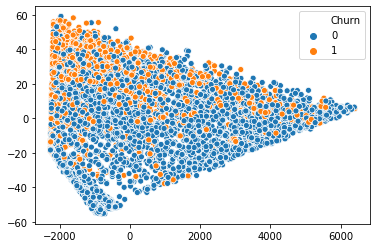

In [21]:
%matplotlib inline
plot=sns.scatterplot(x=points[:,0],y=points[:,1],hue=sample.Churn)

In [22]:
n=.8
train_X,train_y=points[:int(points.shape[0]*n),:],sample.Churn[:int(points.shape[0]*n)]
test_X,test_y=points[int(points.shape[0]*n):,:],sample.Churn[int(points.shape[0]*n):]
rfc=RandomForestClassifier(n_estimators=500,max_depth=3,max_features=.8,n_jobs=3)

rfc.fit(train_X,train_y)
print(rfc.score(train_X,train_y))
print(rfc.score(test_X,test_y))

0.7969777777777778
0.7853589196872779
